In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
#reading from file
T = np.loadtxt("transition.txt", delimiter='\t', dtype=np.float) 
M = np.loadtxt("emission.txt", delimiter='\t', dtype=np.float) 
F = np.loadtxt("beginning_distr.txt", delimiter='\t', dtype=np.float)

In [128]:
print(T) #transition matrix
print(M) # emission matrix
print(F) #initial distribution

[[ 0.95  0.05]
 [ 0.1   0.9 ]]
[[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]
 [ 0.1         0.1         0.1         0.1         0.1         0.5       ]]
[ 0.33333333  0.66666667]


In [203]:
#generation of state/emission sequences
def gen_outcome(probs, r):
    chance = 0
    for j, p in enumerate(probs):
        chance += p
        if (chance > r):
            return j

def gen_sequence(T,M,F,L):
    mt = np.random.RandomState(1234) #mersenne twister generator
    
    rnd = mt.random_sample()
    state = []
    state.append(gen_outcome(F,rnd))
    rnd = mt.random_sample()
    emission = []
    emission.append(gen_outcome(M[state[0]], rnd))
    
    for i in range(L - 1):
        rnd = mt.random_sample()
        state.append(gen_outcome(T[state[-1]], rnd))             
        rnd = mt.random_sample()       
        emission.append(gen_outcome(M[state[-1]], rnd))
        
    return np.array(state), np.array(emission) 

In [218]:
L = 150
states,emis = gen_sequence(T,M,F,L)
print(states,states.size)
print(emis)

[0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0] 150
[3 4 1 4 5 5 5 5 0 5 5 2 3 4 3 2 0 4 5 5 1 4 3 3 3 3 0 5 5 5 5 1 0 5 1 5 1
 5 5 1 3 3 0 4 2 3 5 3 4 4 4 3 1 3 5 1 5 1 1 4 5 3 0 3 0 3 1 0 1 5 5 5 1 0
 1 5 1 5 5 5 5 5 5 4 5 3 5 5 5 5 4 5 0 5 3 1 5 3 1 5 5 5 5 2 2 4 3 2 2 5 0
 5 3 1 2 3 5 1 4 2 0 3 1 3 5 4 0 3 4 3 4 4 4 2 3 3 0 5 5 2 1 1 3 4 1 4 5 1
 4 0]


In [219]:
# viterby algorithm
def viterby(T,M,F,L,y):
    states_num = T[0].size
    obs_num = M[0].size
    V1 = np.zeros((L,states_num))
    V2 = np.zeros((L,states_num))
    
    for i in range(states_num):
        V1[0,i] = F[i]*M[i,y[0]]
        
    for i in range(1,L):
        for st in range(states_num):
            max_tr_prob = V1[i-1,0]*T[0,st]
            prev_state = 0
            for state in range(1,states_num):
                tr_prob = V1[i-1,state]*T[state,st]
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_state = state

            V1[i][st] = max_tr_prob * M[st,y[i]]
            V2[i][st] = prev_state
            
    # Get most probable state and its backtrack       
    max_prob = max( p for p in V1[-1])
    opt_path = []
    for i in range(states_num):
        if V1[-1][i] == max_prob:
            prev = V2[-1][i]
            opt_path.append(prev)
            break
    for i in range(L-2, -1, -1):
        opt_path.insert(0, V2[i,int(prev)])
        prev = V2[i,int(prev)]
    
    #print(V1)
    #print(V2)
    return np.array(opt_path), max_prob

In [220]:
opt , prob = viterby(T,M,F,L,emis)
print(opt,opt.size)
print(prob)
x = (opt - states)
x[abs(x)>0.1].size / L # percentage of error; 0.1 seems promising

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.] 150
3.47474233641e-115


0.1

<IPython.core.display.Javascript object>


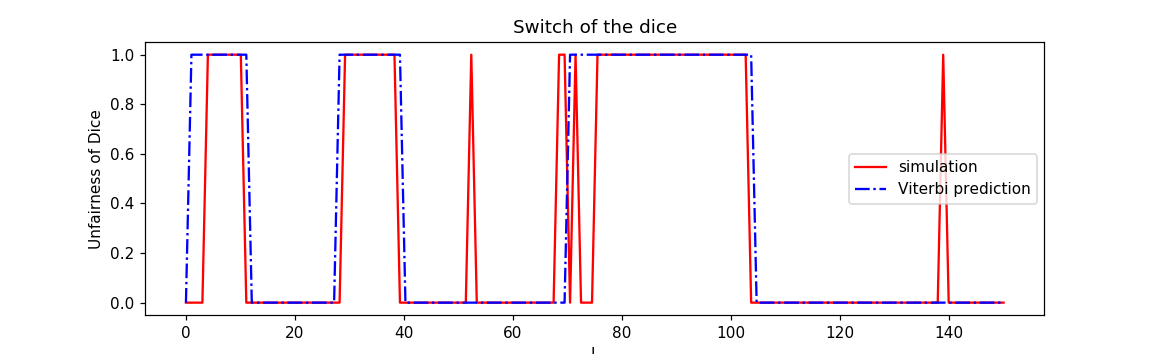

In [227]:
w = np.linspace(0, L,L )
fig, ax = plt.subplots()
ax.set_title('Switch of the dice')
ax.set_ylabel('Unfairness of Dice')
ax.set_xlabel('L')
ax.plot(w, states, label = 'simulation', color='r')
ax.plot(w, opt, '-.', label = 'Viterbi prediction',color='b')

ax.legend()
# the prediction is pretty good

In [228]:
#forward/backward algorithm
def fwd_bkw(obs, F, T, M, L):
    states_num = T[0].size
    obs_num = M[0].size
    fwd = np.zeros((L, states_num))
    bkw = np.zeros((L, states_num)) + 3

    # forward part
    f_curr = np.zeros(states_num)
    for i in range(L):
        for st in range(states_num):
            if i == 0:
                prev_f_sum = F[st]* M[st][obs[0]]
            else:
                prev_f_sum = M[st][obs[i]] * math.fsum([f_prev[k] * T[k][st] for k in range(states_num)])

            f_curr[st] = prev_f_sum
            fwd[i, st] = f_curr[st]

        f_prev = np.copy(f_curr)

    p_fwd = math.fsum(f_curr)  # P(x)

    # backward part
    b_curr = np.zeros(states_num)
    for i in range(L - 1, -1, -1):
        for st in range(states_num):
            if i == L-1:
                b_curr[st] = 1
                bkw[i , st] = b_curr[st]
            else:
                b_curr[st] = math.fsum([T[st][l] * M[l][obs[i+1]] * b_prev[l] for l in range(states_num)])
                bkw[i , st] = b_curr[st]

        b_prev = np.copy(b_curr)

    p_bkw = math.fsum([F[l] * M[l][obs[0]] * b_curr[l] for l in range(states_num)])

    # calculating the posterior probability
    posterior = []
    for i in range(L):
        posterior.append([fwd[i][st] * bkw[i][st] / p_fwd for st in range(states_num)])

    print("Forward probability: ",p_fwd)
    print("Backward probability: ", p_bkw)
    return fwd, bkw, np.array(posterior)

In [230]:
fwd,bkw ,post = fwd_bkw(emis,F,T,M,L)
print(post, post.size,'\n') # the sum of probabilities equals to 1 , which is a good sign
#print(fwd, fwd.size, '\n')
#print(bkw, bkw.size, '\n') 

#backward and forward probabilities seem equal, just as planned

Forward probability:  5.6125583162711124e-111
Backward probability:  5.612558316271143e-111
[[ 0.38232413  0.61767587]
 [ 0.40075304  0.59924696]
 [ 0.37362394  0.62637606]
 [ 0.29135653  0.70864347]
 [ 0.12489911  0.87510089]
 [ 0.06959035  0.93040965]
 [ 0.05770409  0.94229591]
 [ 0.07468551  0.92531449]
 [ 0.14132851  0.85867149]
 [ 0.16077261  0.83922739]
 [ 0.25440559  0.74559441]
 [ 0.53688195  0.46311805]
 [ 0.69204523  0.30795477]
 [ 0.77468937  0.22531063]
 [ 0.8139991   0.1860009 ]
 [ 0.82385614  0.17614386]
 [ 0.8077414   0.1922586 ]
 [ 0.75996413  0.24003587]
 [ 0.66365243  0.33634757]
 [ 0.66317621  0.33682379]
 [ 0.75795236  0.24204764]
 [ 0.80460151  0.19539849]
 [ 0.81959724  0.18040276]
 [ 0.8082351   0.1917649 ]
 [ 0.76650267  0.23349733]
 [ 0.6796627   0.3203373 ]
 [ 0.51704876  0.48295124]
 [ 0.22123579  0.77876421]
 [ 0.12111321  0.87888679]
 [ 0.09407994  0.90592006]
 [ 0.10703346  0.89296654]
 [ 0.1758355   0.8241645 ]
 [ 0.19556849  0.80443151]
 [ 0.17320089  0.

<IPython.core.display.Javascript object>


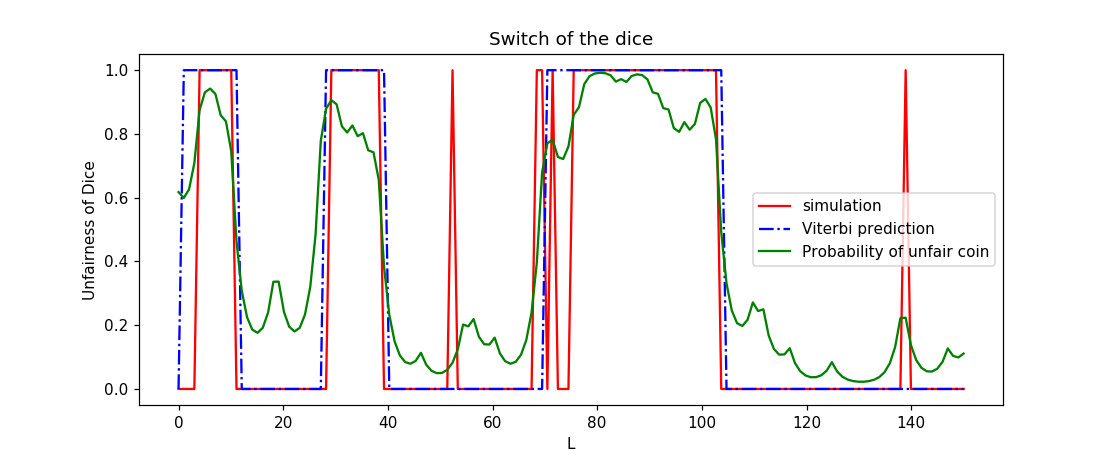

In [224]:
w = np.linspace(0, L,L )
fig, ax = plt.subplots()
ax.set_title('Switch of the dice')
ax.set_ylabel('Unfairness of Dice')
ax.set_xlabel('L')
ax.plot(w, states, label = 'simulation', color='r')
ax.plot(w, opt, '-.', label = 'Viterbi prediction',color='b')
ax.plot(w, post[:,1], '-', label = 'Probability of unfair coin',color='g')
ax.legend()
# the probability prediction fits the simulation

In [181]:
# logarithmic summation
def log_sum(arr):
    s = arr[0]
    for i in range(len(arr) - 1):
        s = math.log(s)+math.log1p(math.exp(math.log(arr[i+1])-math.log(s)))
        s = math.exp(s)
    return s

